<a href="https://colab.research.google.com/github/EmreYY20/ToS-Simplification/blob/main/ToS_Summarization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Terms of Service Simplification**

##### Author: Emre Iyigün

---

## Contents

### 1. [Data preperation](#data-prep)
### 2. [Understanding the data](#data-under)
### 3. [Fine-Tuning](#finet)



---

<a name="data-prep"></a>
# 1. Data preperation

In the following different Terms of Services will be collected from https://tosdr.org/.

Then the data will be processed and relevant data will be extracted.

In [ ]:
!pip install spacy_language_detection

In [ ]:
import os
import json
import requests
import concurrent.futures

import re
import pandas as pd
import spacy
from spacy.language import Language
from spacy_language_detection import LanguageDetector

## 1.1. Scraping the data

In [ ]:
headers = {
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.36 Edge/16.16299'
}

In [ ]:
# Define a function to retrieve service IDs
def get_ids():
    id_url = "https://api.tosdr.org/all-services/v1/"
    r = requests.get(id_url, headers=headers)
    j = r.json()
    tod_ids = []

    # Iterate through services and check if ToS data is already downloaded
    for service in j['parameters']['services']:
        tos_id = service['id']
        file_path = os.path.join("data", "raw_data", f"tos_{tos_id}.json")

        if not os.path.isfile(file_path):
            tod_ids.append(tos_id)
    return tod_ids

In [ ]:
# Define a function to download ToS data by ID
def download_tos(tos_id):
    url = f'https://api.tosdr.org/rest-service/v2/{tos_id}.json'

    # Create a session for making HTTP requests
    with requests.Session() as session:
        try:
            r = session.get(url, headers=headers)
            j = r.json()

            # Check for errors and handle if error code 193 is encountered
            if j.get('error') == 193:
                return None

            directory = 'data/raw_data'
            if not os.path.exists(directory):
                os.makedirs(directory)

            # Save the ToS data in a JSON file
            with open(f"{directory}/tos_{tos_id}.json", 'w') as outfile:
                json.dump(j, outfile)
            return tos_id
        except Exception as e:
            print(f"Error downloading ToS {tos_id}: {e}")
            return None

In [ ]:
# Main program execution
if __name__ == "__main__":
    ids = get_ids()

    # Use a ThreadPoolExecutor to concurrently download ToS data
    with concurrent.futures.ThreadPoolExecutor(max_workers=10) as executor:
        results = list(executor.map(download_tos, ids))

    # Filter and count downloaded ToS data
    downloaded_tos = [result for result in results if result is not None]
    print(f"Downloaded {len(downloaded_tos)} ToS.")

## 1.2. Processing the data

In [ ]:
# Specify the path to JSON files containing data
path_to_json = 'data/raw_data/'

# get all JSON files in the specified directory
json_files = [pos_json for pos_json in os.listdir(path_to_json) if pos_json.endswith('.json')]

In [ ]:
# Define a function to get a language detector using a specific spaCy model
def get_lang_detector(nlp, name):
    return LanguageDetector(seed=42)  # We use the seed 42 for consistency

In [ ]:
# Initialize a list to store downloaded terms of services
data = []

# Load data from each JSON file into the 'data' list
for json_file in json_files:
    with open(path_to_json + json_file, 'r') as f:
        data.append(json.load(f))

In [ ]:
# Initialize a list to store reviewed terms of services
reviewed_terms = []

# Filter and collect terms of services that are comprehensively reviewed
for doc in data:
    if doc['parameters']['is_comprehensively_reviewed'] is True:
        reviewed_terms.append(doc)

# Create summaries by merging quotes from the reviewed terms of services
final_data = []

# Load the spaCy model and add a custom language detector pipeline
nlp_model = spacy.load('en_core_web_sm')
Language.factory("language_detector", func=get_lang_detector)
nlp_model.add_pipe('language_detector', last=True)

# Process each reviewed term of service
for doc in reviewed_terms:
    legal_contracts = {}

    # Group quotes by document ID
    for point in doc['parameters']['points']:
        if point['quoteStart'] is not None and point['quoteText'] is not None:
            legal_contracts.setdefault(point['document_id'], []).append(point)

    # Sort quotes by 'quoteStart'
    for doc_id, value in legal_contracts.items():
        legal_contracts[doc_id] = sorted(value, key=lambda i: i['quoteStart'])

        # Initialize variables to store plain text and summary
        plain_text = ""
        summary = ""

        # Concatenate quote text and titles to form plain text and summary
        for point in legal_contracts[doc_id]:
            plain_text += point['quoteText'] + " "
            summary += point['title'] + ". "

        # Perform regex preprocessing to remove HTML tags and newline characters
        plain_text = re.sub(r"<[^>]*>", '', plain_text)
        plain_text = re.sub(r"\n", ' ', plain_text)

        # Language check using the custom language detector
        doc = nlp_model(plain_text)

        # Check if the detected language is English ('en')
        if doc._.language['language'] == 'en':
            final_data.append([plain_text, summary])

# Create a Pandas DataFrame from the processed data
df = pd.DataFrame(final_data, columns=['plain_text', 'summary'])

# Export the DataFrame to a JSON file in 'records' format with lines
df.to_json('data/dataset.json', orient='records', lines=True)

<a name="data-under"></a>
# 2. Understanding the data

In [ ]:
!pip install datasets

In [ ]:
from datasets import load_dataset
from wordcloud import WordCloud
from matplotlib import pyplot as plt
import seaborn as sns

import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from string import punctuation
from collections import Counter
import numpy as np

## 2.1. Read in data

In [ ]:
dataset = load_dataset("EE21/ToS-Summaries", split='train')

In [ ]:
dataset = dataset.train_test_split(test_size=0.2)

dataset

## 2.2. Data visualizations

In [ ]:
# Convert the training and testing splits to DataFrames
train_df = pd.DataFrame(dataset['train'])
test_df = pd.DataFrame(dataset['test'])

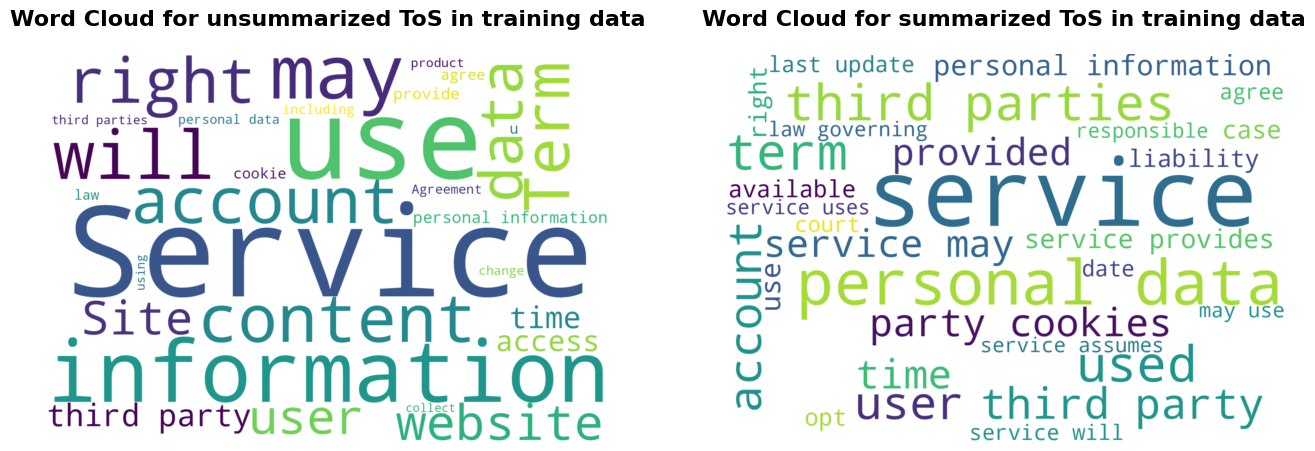

In [ ]:
# Create a word cloud for the "plain_text" column in the training data with fewer words
train_plain_text = " ".join(train_df['plain_text'].tolist())
wordcloud_plain_text = WordCloud(width=1600, height=1100, background_color='white', max_words=30).generate(train_plain_text)

# Create a word cloud for the "summary" column in the training data with fewer words
train_summary = " ".join(train_df['summary'].tolist())
wordcloud_summary = WordCloud(width=1600, height=1100, background_color='white', max_words=30).generate(train_summary)

# Plot the word clouds side by side
plt.figure(figsize=(16, 10))

plt.subplot(1, 2, 1)
plt.imshow(wordcloud_plain_text, interpolation='bilinear')
plt.title("Word Cloud for unsummarized ToS in training data", fontdict={'fontsize': 16, 'fontweight': 'bold'}, pad=20)
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(wordcloud_summary, interpolation='bilinear')
plt.title("Word Cloud for summarized ToS in training data", fontdict={'fontsize': 16, 'fontweight': 'bold'}, pad=20)
plt.axis('off')

plt.show()

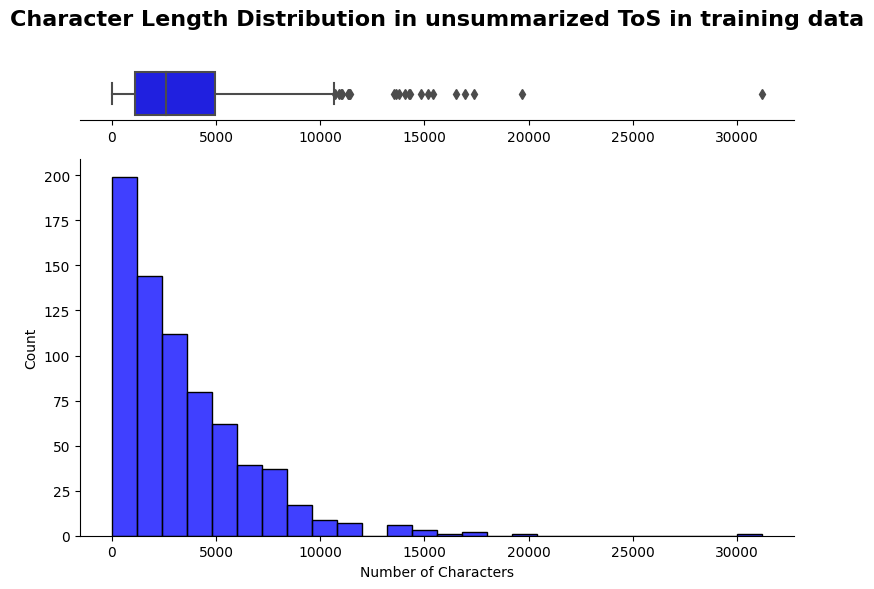

In [ ]:
# Choose a color for both the box plot and histogram
plot_color = 'blue'

# Create subplots with shared x-axis and custom heights
fig, (ax_box_plain, ax_hist_plain) = plt.subplots(2, figsize=(8, 6),
                                                  gridspec_kw={"height_ratios": [0.1, 0.7]})

# Character Length Distribution in 'plain_text' (Box Plot)
sns.boxplot(x=train_df['plain_text'].str.len(), ax=ax_box_plain, color=plot_color)
ax_box_plain.set(yticks=[])
ax_box_plain.set_title('Character Length Distribution in unsummarized ToS in training data', fontsize=16, fontweight='bold', pad=30)

# Remove x-axis label in the box plot
ax_box_plain.set_xlabel("")

# Character Length Distribution in 'plain_text' (Histogram)
sns.histplot(train_df['plain_text'].str.len(), bins=26, ax=ax_hist_plain, color=plot_color)

# Set x-axis label to "Number of Characters" for the histogram
ax_hist_plain.set_xlabel("Number of Characters")

# Remove spines
sns.despine(ax=ax_hist_plain)
sns.despine(ax=ax_box_plain, left=True)

# Adjust spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()

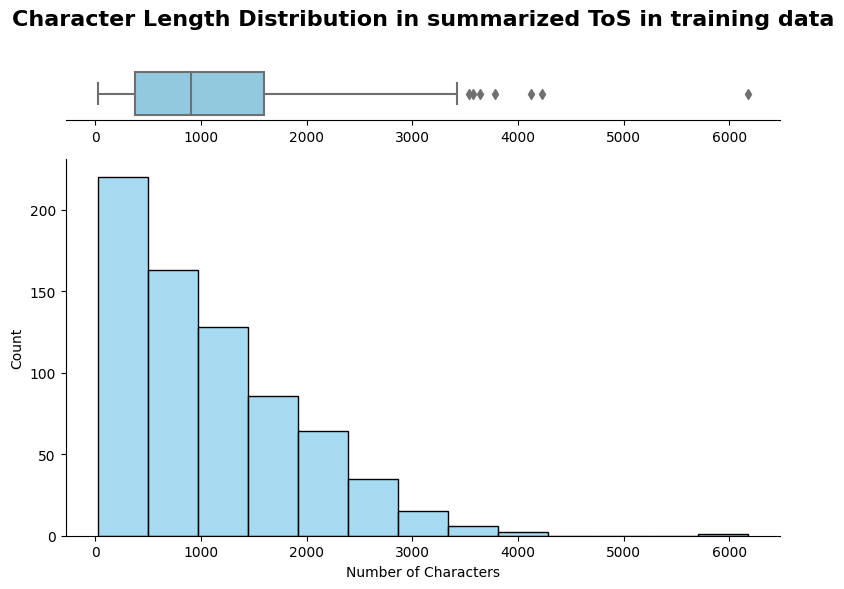

In [ ]:
# Choose a color for both the box plot and histogram for 'summaries'
plot_color_summary = 'skyblue'

# Create subplots with shared x-axis and custom heights
fig, (ax_box_summary, ax_hist_summary) = plt.subplots(2, figsize=(8, 6),
                                                      gridspec_kw={"height_ratios": [0.1, 0.7]})

# Character Length Distribution in 'summaries' (Box Plot)
sns.boxplot(x=train_df['summary'].str.len(), ax=ax_box_summary, color=plot_color_summary)
ax_box_summary.set(yticks=[])
ax_box_summary.set_title('Character Length Distribution in summarized ToS in training data', fontsize=16, fontweight='bold', pad=30)

# Remove x-axis label in the box plot for 'summaries'
ax_box_summary.set_xlabel("")

# Character Length Distribution in 'summaries' (Histogram)
sns.histplot(train_df['summary'].str.len(), bins=13, ax=ax_hist_summary, color=plot_color_summary)

# Set x-axis label to "Number of Characters" for the histogram for 'summaries'
ax_hist_summary.set_xlabel("Number of Characters")

# Remove spines
sns.despine(ax=ax_hist_summary)
sns.despine(ax=ax_box_summary, left=True)

# Adjust spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()

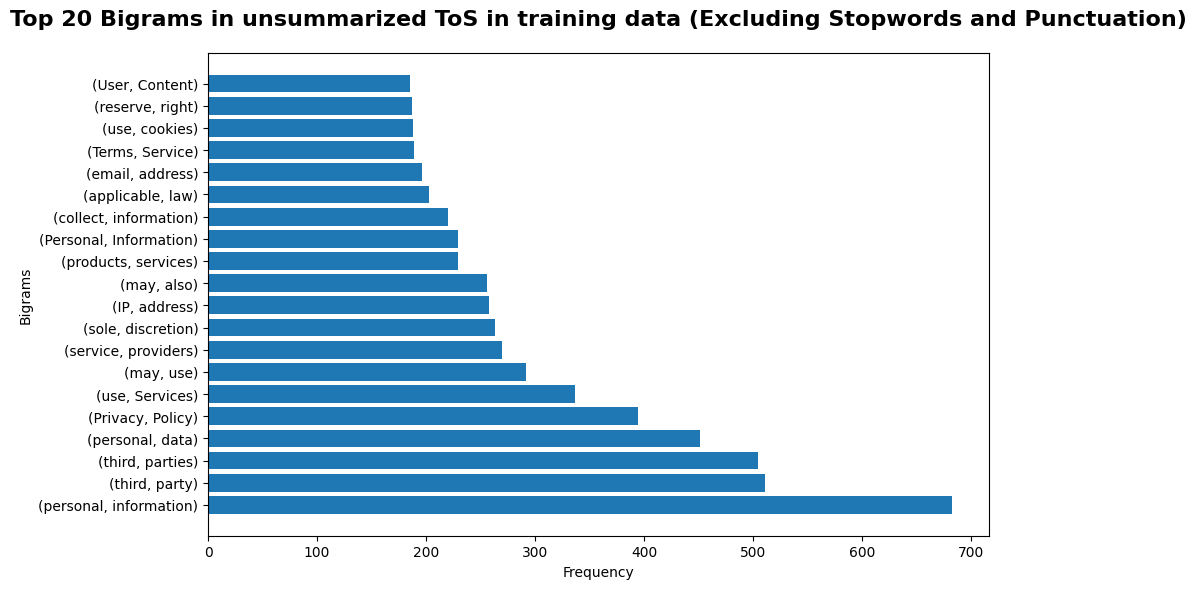

In [ ]:
from nltk.util import bigrams

# Load the stopwords
stop_words = set(stopwords.words('english'))

# Tokenize the text in 'plain_text' column into words, excluding stopwords and punctuation
tokens_plain = train_df['plain_text'].apply(lambda x: [word for word in word_tokenize(x) if word.lower() not in stop_words and word not in punctuation])

# Create bigrams for each row
bigrams_plain = tokens_plain.apply(lambda x: list(bigrams(x)))

# Flatten the list of bigrams across all rows
all_bigrams = [bigram for sublist in bigrams_plain for bigram in sublist]

# Count the frequency of each bigram
bigram_freq = Counter(all_bigrams)

# Extract the bigram and frequency data
bigrams, frequencies = zip(*bigram_freq.items())

# Sort the bigrams and frequencies together by frequency in descending order
sorted_bigrams, sorted_frequencies = zip(*sorted(zip(bigrams, frequencies), key=lambda x: x[1], reverse=True))

# Flatten the sorted bigrams and frequencies and format bigrams as tuples separated by a comma
sorted_bigrams_flat = [f"({', '.join(bigram)})" for bigram in sorted_bigrams]
sorted_frequencies_flat = sorted_frequencies

# Create a horizontal bar chart to visualize the top bigram frequencies
plt.figure(figsize=(10, 6))
plt.barh(range(len(sorted_bigrams_flat[:20])), sorted_frequencies_flat[:20], tick_label=sorted_bigrams_flat[:20])
plt.xlabel("Frequency")
plt.ylabel("Bigrams")
plt.title("Top 20 Bigrams in unsummarized ToS in training data (Excluding Stopwords and Punctuation)", fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()


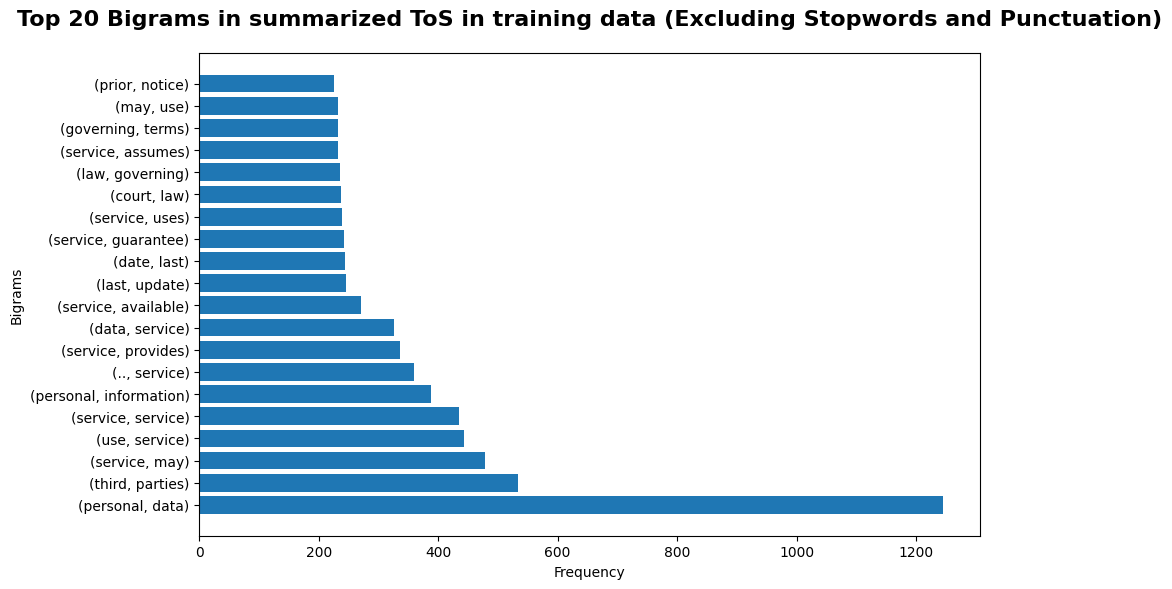

In [ ]:
from nltk.util import bigrams

# Tokenize the text in 'summary' column into words, excluding stopwords and punctuation
tokens_summary = train_df['summary'].apply(lambda x: [word for word in word_tokenize(x) if word.lower() not in stop_words and word not in punctuation])

# Create bigrams for each row in the 'summary' column
bigrams_summary = tokens_summary.apply(lambda x: list(bigrams(x)))

# Flatten the list of bigrams across all rows
all_bigrams_summary = [bigram for sublist in bigrams_summary for bigram in sublist]

# Count the frequency of each bigram
bigram_freq = Counter(all_bigrams_summary)

# Extract the bigram and frequency data
bigrams, frequencies = zip(*bigram_freq.items())

# Sort the bigrams and frequencies together by frequency in descending order
sorted_bigrams, sorted_frequencies = zip(*sorted(zip(bigrams, frequencies), key=lambda x: x[1], reverse=True))

# Flatten the sorted bigrams and frequencies and format bigrams as tuples separated by a comma
sorted_bigrams_flat = [f"({', '.join(bigram)})" for bigram in sorted_bigrams]
sorted_frequencies_flat = sorted_frequencies

# Create a horizontal bar chart to visualize the top bigram frequencies for the 'summary' column
plt.figure(figsize=(10, 6))
plt.barh(range(len(sorted_bigrams_flat[:20])), sorted_frequencies_flat[:20], tick_label=sorted_bigrams_flat[:20])
plt.xlabel("Frequency")
plt.ylabel("Bigrams")
plt.title("Top 20 Bigrams in summarized ToS in training data (Excluding Stopwords and Punctuation)", fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

In [ ]:
# visualize bigram similarity

<a name="finet"></a>
# 3. Fine-Tuning

In [ ]:
!pip install evaluate rouge-score
!pip install transformers[torch]
!pip install accelerate -U

In [ ]:
from transformers import AutoTokenizer, DataCollatorForSeq2Seq, AutoModelForSeq2SeqLM, Seq2SeqTrainingArguments, Seq2SeqTrainer
from datasets import load_dataset
import evaluate
rouge = evaluate.load("rouge")

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split

from huggingface_hub import notebook_login

In [ ]:
# Authenticate with Hugging Face (login) to access the model hub
#notebook_login()

In [ ]:
# Define the checkpoint (pre-trained model) you want to use for summarization
checkpoint = "facebook/bart-large-cnn"

# Load the tokenizer associated with the specified checkpoint
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

In [ ]:
# Define a prefix that will be added to each document for summarization
prefix = "summarize: "

# Define a function for preprocessing data for a summarization model
def preprocess_function(data):
    # Combine the prefix with each document and create a list of inputs
    inputs = [prefix + doc for doc in data["plain_text"]]

    # Tokenize the inputs with a maximum length of 256 tokens and truncation
    model_inputs = tokenizer(inputs, max_length=256, truncation=True)

    # Tokenize the summary (target) text with a maximum length of 128 tokens and truncation
    labels = tokenizer(text_target=data["summary"], max_length=256, truncation=True)

    # Add the tokenized labels (input_ids) to the model_inputs dictionary
    model_inputs["labels"] = labels["input_ids"]

    # Return the preprocessed data as model inputs
    return model_inputs

In [ ]:
# Apply a preprocessing function to the dataset in batches
tokenized_dataset = dataset.map(preprocess_function, batched=True)

In [ ]:
tokenized_dataset

In [ ]:
def compute_metrics(eval_pred):
    # Extract predictions and labels from the evaluation prediction tuple
    predictions, labels = eval_pred

    # Decode the model's predictions into human-readable text, skipping special tokens
    decoded_preds = tokenizer.batch_decode(predictions, skip_special_tokens=True)

    # Replace label values of -100 (usually representing padding) with the pad token ID
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)

    # Decode the labels into human-readable text, skipping special tokens
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

    # Compute ROUGE (a metric for text summarization) scores using the decoded predictions and labels
    result = rouge.compute(predictions=decoded_preds, references=decoded_labels, use_stemmer=True)

    # Calculate the average length of generated predictions (excluding padding)
    prediction_lens = [np.count_nonzero(pred != tokenizer.pad_token_id) for pred in predictions]
    result["gen_len"] = np.mean(prediction_lens)

    # Round the computed metrics to four decimal places and return as a dictionary
    return {k: round(v, 4) for k, v in result.items()}

In [ ]:
# Load a pre-trained sequence-to-sequence language model from the specified checkpoint
model = AutoModelForSeq2SeqLM.from_pretrained(checkpoint)

In [ ]:
# Create a data collator for sequence-to-sequence tasks using the provided tokenizer and model checkpoint
data_collator = DataCollatorForSeq2Seq(tokenizer=tokenizer, model=checkpoint)

In [ ]:
training_args = Seq2SeqTrainingArguments(
    output_dir="BART-ToSSimplify",
    evaluation_strategy="epoch",
    learning_rate=5e-05,
    lr_scheduler_type="linear",
    per_device_train_batch_size=2,
    per_device_eval_batch_size=2,
    save_total_limit=3,
    num_train_epochs=5,
    warmup_steps=500,
    predict_with_generate=True,
    push_to_hub=True,
    fp16=True
)

trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["test"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

trainer.train()

In [ ]:
# Push model to huggingface
#trainer.push_to_hub()